In [ ]:
# Large Language Models - Transformers - 2
# original paper:  Vawani et al. Attention is all you need. 2017.
# https://arxiv.org/pdf/1706.03762.pdf

# simplified:
# https://pub.aimind.so/transformer-model-and-variants-of-transformer-chatgpt-3d423676e29c
# https://huggingface.co/learn/nlp-course/chapter1/4?fw=pt

# implementation sources:
# https://buomsoo-kim.github.io/attention/2020/01/12/Attention-mechanism-3.md/
# https://buomsoo-kim.github.io/attention/2020/04/19/Attention-mechanism-17.md/
# https://buomsoo-kim.github.io/attention/2020/04/21/Attention-mechanism-19.md/

# video overview
# https://www.youtube.com/watch?v=iDulhoQ2pro&ab_channel=YannicKilcher

# Huggingface overview:
# https://huggingface.co/docs/transformers/en/task_summary


"The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions entirely."

++ While LSTM-based decoders are autoregressive by nature, Transformers are not. Instead, all predictions are generated at once based on the real target tokens ++



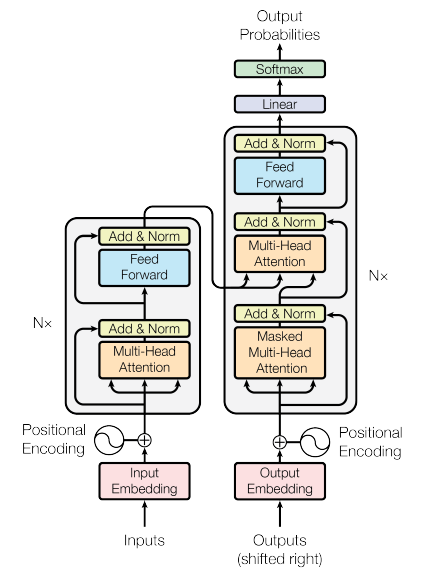

"An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
of the values, where the weight assigned to each value is computed by a compatibility function of the
query with the corresponding key."


"Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
we found it beneficial to linearly project the queries, keys and values h times with different, learned
linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of
queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional
output values. These are concatenated and once again projected, resulting in the final values."

In [1]:
!wget https://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip

with open("deu.txt") as f:
  sentences = f.readlines()

--2024-04-02 20:18:52--  https://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10364105 (9.9M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   9.88M  7.56MB/s    in 1.3s    

2024-04-02 20:18:54 (7.56 MB/s) - ‘deu-eng.zip’ saved [10364105/10364105]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [2]:
print(len(sentences))
print(sentences[0:5])

277891
['Go.\tGeh.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)\n', 'Hi.\tHallo!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)\n', 'Hi.\tGrüß Gott!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)\n', 'Run!\tLauf!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)\n', 'Run.\tLauf!\tCC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #941078 (Fingerhut)\n']


In [3]:
import re
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
## source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [5]:
NUM_INSTANCES = 30000     # start with 10000
MAX_SENT_LEN = 10

eng_sentences, deu_sentences = [], []
eng_words, deu_words = set(), set()
for i in tqdm(range(NUM_INSTANCES)):
  rand_idx = np.random.randint(len(sentences))
  # find only letters in sentences
  eng_sent, deu_sent = ["<sos>"], ["<sos>"]
  eng_sent += re.findall(r"\w+", sentences[rand_idx].split("\t")[0])
  deu_sent += re.findall(r"\w+", sentences[rand_idx].split("\t")[1])

  # change to lowercase
  eng_sent = [x.lower() for x in eng_sent]
  deu_sent = [x.lower() for x in deu_sent]
  eng_sent.append("<eos>")
  deu_sent.append("<eos>")

  if len(eng_sent) >= MAX_SENT_LEN:
    eng_sent = eng_sent[:MAX_SENT_LEN]
  else:
    for _ in range(MAX_SENT_LEN - len(eng_sent)):
      eng_sent.append("<pad>")

  if len(deu_sent) >= MAX_SENT_LEN:
    deu_sent = deu_sent[:MAX_SENT_LEN]
  else:
    for _ in range(MAX_SENT_LEN - len(deu_sent)):
      deu_sent.append("<pad>")

  # add parsed sentences
  eng_sentences.append(eng_sent)
  deu_sentences.append(deu_sent)

  # update unique words
  eng_words.update(eng_sent)
  deu_words.update(deu_sent)

eng_words, deu_words = list(eng_words), list(deu_words)

# encode each token into index
for i in tqdm(range(len(eng_sentences))):
  eng_sentences[i] = [eng_words.index(x) for x in eng_sentences[i]]
  deu_sentences[i] = [deu_words.index(x) for x in deu_sentences[i]]

idx = 10
print(eng_sentences[idx])
print([eng_words[x] for x in eng_sentences[idx]])
print(deu_sentences[idx])
print([deu_words[x] for x in deu_sentences[idx]])

100%|██████████| 30000/30000 [01:21<00:00, 366.37it/s]

[2548, 1822, 4289, 4216, 6811, 5577, 2168, 4090, 4692, 3656]
['<sos>', 'is', 'there', 'something', 'in', 'particular', 'that', 'you', 'want', 'to']
[4413, 9152, 7027, 11229, 12163, 4028, 11853, 5599, 1350, 7147]
['<sos>', 'gibt', 'es', 'etwas', 'besonderes', 'was', 'du', 'trinken', 'willst', '<eos>']


In [6]:
ENG_VOCAB_SIZE = len(eng_words)
DEU_VOCAB_SIZE = len(deu_words)

print(ENG_VOCAB_SIZE)
print(DEU_VOCAB_SIZE)

NUM_EPOCHS = 25
HIDDEN_SIZE = 16
EMBEDDING_DIM = 30
BATCH_SIZE = 128
NUM_HEADS = 2
NUM_LAYERS = 3
LEARNING_RATE = 1e-2
DROPOUT = .3
DEVICE = torch.device('cuda')

7464
12367


In [7]:
class MTDataset(torch.utils.data.Dataset):
  def __init__(self):
    # import and initialize dataset
    self.source = np.array(eng_sentences, dtype = int)
    self.target = np.array(deu_sentences, dtype = int)

  def __getitem__(self, idx):
    # get item by index
    return self.source[idx], self.target[idx]

  def __len__(self):
    # returns length of data
    return len(self.source)

np.random.seed(777)   # for reproducibility
dataset = MTDataset()
NUM_INSTANCES = len(dataset)
TEST_RATIO = 0.3
TEST_SIZE = int(NUM_INSTANCES * 0.3)

indices = list(range(NUM_INSTANCES))

test_idx = np.random.choice(indices, size = TEST_SIZE, replace = False)
train_idx = list(set(indices) - set(test_idx))
train_sampler, test_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = test_sampler)

In [8]:
for i, (x, y) in enumerate(train_loader):
  print(x,y)

tensor([[2548, 5494, 4477,  ..., 7430, 4196, 5703],
        [2548, 5572, 4090,  ..., 5703, 5703, 5703],
        [2548, 7299, 3581,  ..., 1205, 4196, 5703],
        ...,
        [2548, 2486, 2332,  ..., 5703, 5703, 5703],
        [2548, 5494, 5835,  ..., 1141, 4196, 5703],
        [2548, 5494, 4477,  ..., 5703, 5703, 5703]]) tensor([[ 4413, 11243, 10441,  ...,  7147,  9566,  9566],
        [ 4413,   905, 11853,  ...,  9566,  9566,  9566],
        [ 4413,  3881,  9820,  ...,  7474,  8343,  7147],
        ...,
        [ 4413,  4313,  8746,  ...,  9566,  9566,  9566],
        [ 4413, 11243,  5913,  ...,  7147,  9566,  9566],
        [ 4413, 11243,  5913,  ...,  9566,  9566,  9566]])
tensor([[2548, 2486, 2332,  ..., 3796,  884, 3322],
        [2548, 2446, 2662,  ..., 5703, 5703, 5703],
        [2548, 4090,  323,  ..., 6149,  972, 3659],
        ...,
        [2548, 2777,  259,  ..., 5703, 5703, 5703],
        [2548, 2486, 3576,  ..., 4196, 5703, 5703],
        [2548, 1830, 2332,  ..., 5703, 

In [9]:
class TransformerNet(nn.Module):
  def __init__(self, num_src_vocab, num_tgt_vocab, embedding_dim, hidden_size, nheads, n_layers, max_src_len, max_tgt_len, dropout):
    super(TransformerNet, self).__init__()
    # embedding layers
    self.enc_embedding = nn.Embedding(num_src_vocab, embedding_dim)
    self.dec_embedding = nn.Embedding(num_tgt_vocab, embedding_dim)

    # positional encoding layers
    self.enc_pe = PositionalEncoding(embedding_dim, max_len = max_src_len)
    self.dec_pe = PositionalEncoding(embedding_dim, max_len = max_tgt_len)

    # encoder/decoder layers
    enc_layer = nn.TransformerEncoderLayer(embedding_dim, nheads, hidden_size, dropout)
    dec_layer = nn.TransformerDecoderLayer(embedding_dim, nheads, hidden_size, dropout)
    self.encoder = nn.TransformerEncoder(enc_layer, num_layers = n_layers)
    self.decoder = nn.TransformerDecoder(dec_layer, num_layers = n_layers)

    # final dense layer
    self.dense = nn.Linear(embedding_dim, num_tgt_vocab)
    self.log_softmax = nn.LogSoftmax()

  def forward(self, src, tgt):
    src, tgt = self.enc_embedding(src).permute(1, 0, 2), self.dec_embedding(tgt).permute(1, 0, 2)
    src, tgt = self.enc_pe(src), self.dec_pe(tgt)
    memory = self.encoder(src)
    transformer_out = self.decoder(tgt, memory)
    final_out = self.dense(transformer_out)
    return self.log_softmax(final_out)

In [10]:
model = TransformerNet(ENG_VOCAB_SIZE, DEU_VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, NUM_HEADS, NUM_LAYERS, MAX_SENT_LEN, MAX_SENT_LEN, DROPOUT).to(DEVICE)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [11]:
%%time
import matplotlib.pyplot as plt
interval = 100
loss_trace = []
current_loss = 0

for epoch in tqdm(range(NUM_EPOCHS)):
  current_loss = 0
  for i, (x, y) in enumerate(train_loader):
    x, y  = x.to(DEVICE), y.to(DEVICE)
    outputs = model(x, y)
    loss = criterion(outputs.permute(1, 2, 0), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if(i % interval == 0):
      print("\nHere is the current loss: ", loss.item())
  loss_trace.append(current_loss)

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)



Here is the current loss:  2.359769344329834

Here is the current loss:  0.36852675676345825


  4%|▍         | 1/25 [00:04<01:49,  4.54s/it]


Here is the current loss:  0.30695658922195435

Here is the current loss:  0.3053963780403137


  8%|▊         | 2/25 [00:08<01:35,  4.13s/it]


Here is the current loss:  0.2740956246852875

Here is the current loss:  0.23246285319328308


 12%|█▏        | 3/25 [00:11<01:19,  3.63s/it]


Here is the current loss:  0.24601073563098907

Here is the current loss:  0.25827643275260925


 16%|█▌        | 4/25 [00:14<01:11,  3.40s/it]


Here is the current loss:  0.2723725438117981

Here is the current loss:  0.2006344497203827


 20%|██        | 5/25 [00:18<01:10,  3.52s/it]


Here is the current loss:  0.2820524275302887

Here is the current loss:  0.21216623485088348


 24%|██▍       | 6/25 [00:21<01:04,  3.41s/it]


Here is the current loss:  0.2416020929813385

Here is the current loss:  0.24237708747386932


 28%|██▊       | 7/25 [00:24<00:59,  3.30s/it]


Here is the current loss:  0.2736791968345642

Here is the current loss:  0.24454531073570251


 32%|███▏      | 8/25 [00:27<00:55,  3.24s/it]


Here is the current loss:  0.23163656890392303

Here is the current loss:  0.2883191704750061


 36%|███▌      | 9/25 [00:31<00:55,  3.48s/it]


Here is the current loss:  0.2494497299194336

Here is the current loss:  0.2702265977859497


 40%|████      | 10/25 [00:34<00:50,  3.35s/it]


Here is the current loss:  0.19818665087223053

Here is the current loss:  0.25666946172714233


 44%|████▍     | 11/25 [00:37<00:46,  3.29s/it]


Here is the current loss:  0.24318942427635193

Here is the current loss:  0.26095089316368103


 48%|████▊     | 12/25 [00:40<00:42,  3.25s/it]


Here is the current loss:  0.24765324592590332

Here is the current loss:  0.2527274489402771


 52%|█████▏    | 13/25 [00:44<00:40,  3.39s/it]


Here is the current loss:  0.2257724106311798

Here is the current loss:  0.2434544563293457


 56%|█████▌    | 14/25 [00:47<00:36,  3.31s/it]


Here is the current loss:  0.25956934690475464

Here is the current loss:  0.2686900496482849


 60%|██████    | 15/25 [00:51<00:32,  3.30s/it]


Here is the current loss:  0.23709142208099365

Here is the current loss:  0.2634306252002716


 64%|██████▍   | 16/25 [00:54<00:30,  3.41s/it]


Here is the current loss:  0.26317960023880005

Here is the current loss:  0.26212388277053833


 68%|██████▊   | 17/25 [00:58<00:26,  3.37s/it]


Here is the current loss:  0.2005760371685028

Here is the current loss:  0.2740681767463684


 72%|███████▏  | 18/25 [01:01<00:23,  3.29s/it]


Here is the current loss:  0.2741228938102722

Here is the current loss:  0.21096935868263245


 76%|███████▌  | 19/25 [01:04<00:19,  3.23s/it]


Here is the current loss:  0.256161630153656

Here is the current loss:  0.2565688490867615


 80%|████████  | 20/25 [01:08<00:17,  3.42s/it]


Here is the current loss:  0.2653774619102478

Here is the current loss:  0.25787919759750366


 84%|████████▍ | 21/25 [01:11<00:13,  3.37s/it]


Here is the current loss:  0.3131876587867737

Here is the current loss:  0.25538399815559387


 88%|████████▊ | 22/25 [01:14<00:09,  3.28s/it]


Here is the current loss:  0.2560061812400818

Here is the current loss:  0.27155834436416626


 92%|█████████▏| 23/25 [01:17<00:06,  3.24s/it]


Here is the current loss:  0.2586890161037445

Here is the current loss:  0.24255283176898956


 96%|█████████▌| 24/25 [01:21<00:03,  3.41s/it]


Here is the current loss:  0.21972060203552246

Here is the current loss:  0.2351767122745514


100%|██████████| 25/25 [01:24<00:00,  3.38s/it]

CPU times: user 1min 22s, sys: 578 ms, total: 1min 23s
Wall time: 1min 24s


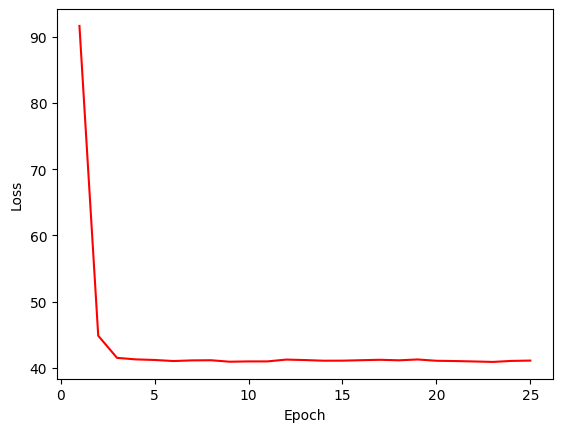

In [12]:
# loss curve
plt.plot(range(1, NUM_EPOCHS+1), loss_trace, 'r-')
#plt.plot(range(1, len(loss_trace)), loss_trace, 'r-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

"Not included is the positioning encoding, which is a critical element of Transformer. Also, the building blocks of nn.Transformer can be decomposed and modified for better performance and more applications. And there are a number of parameters that can be fine-tuned for optimal performance."
